# Final Project

## Imports

In [2]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import stan
import seaborn as sns

import nest_asyncio
nest_asyncio.apply()

## Helper Functions

In [3]:
def clean_data_frame(df: DataFrame):
    """
    Cleans the data by removing rows with missing values and resetting the index.

    Parameters
    ----------
    df : DataFrame
        The input DataFrame containing the data to be cleaned.

    Returns
    -------
    DataFrame
        The cleaned DataFrame with missing values removed and index reset.
    """
    df = df[['correct', 'rt']].dropna(ignore_index=True)
    df['correct'] = df['correct'].astype(int)
    df = df[df['rt'] >= 0]
    return df

In [3]:
def simulate_diffusion(v, a, beta, tau, dt=1e-3, scale=1.0, max_time=10.0):
    """
    Simulates one realization of the diffusion process given
    a set of parameters and a step size `dt`.

    Parameters:
    -----------
    v        : float
        The drift rate (rate of information uptake)
    a        : float
        The boundary separation (decision threshold).
    beta     : float in [0, 1]
        Relative starting point (prior option preferences)
    tau      : float
        Non-decision time (additive constant)
    dt       : float, optional (default: 1e-3 = 0.001)
        The step size for the Euler algorithm.
    scale    : float, optional (default: 1.0)
        The scale (sqrt(var)) of the Wiener process. Not considered
        a parameter and typically fixed to either 1.0 or 0.1.
    max_time : float, optional (default: .10)
        The maximum number of seconds before forced termination.

    Returns:
    --------
    (x, c) - a tuple of response time (y - float) and a
        binary decision (c - int)
    """

    # Inits (process starts at relative starting point)
    y = beta * a
    num_steps = tau
    const = scale * np.sqrt(dt)

    # Loop through process and check boundary conditions
    while (y <= a and y >= 0) and num_steps <= max_time:

        # Perform diffusion equation
        z = np.random.normal()
        y += v * dt + const * z

        # Increment step counter
        num_steps += dt

    if y >= a:
        c = 1.0
    else:
        c = 0.0
    return (round(num_steps, 4), c)

## Cleaning and Viewing Data

In [4]:
df_20 = pd.read_csv("../data/a20_0.csv")

df_20 = clean_data_frame(df_20)

df_45 = pd.read_csv("../data/a45_0.csv")
df_45 = df_45 = clean_data_frame(df_45)

In [6]:
df_45

,correct,rt
1,1,1831.985
2,0,2485.145
3,1,1784.175
4,1,1546.255
5,1,1524.910
...,...,...
572,1,2692.180
573,1,549.740
574,1,551.315
575,1,541.880


20 degrees:


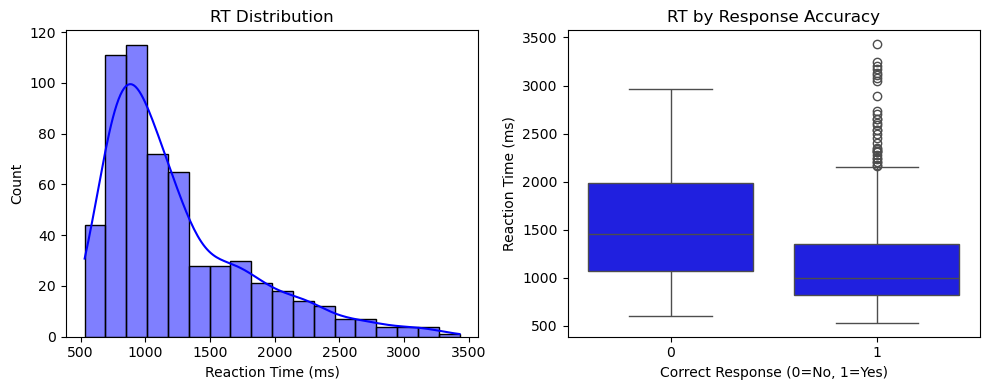

45 degrees:


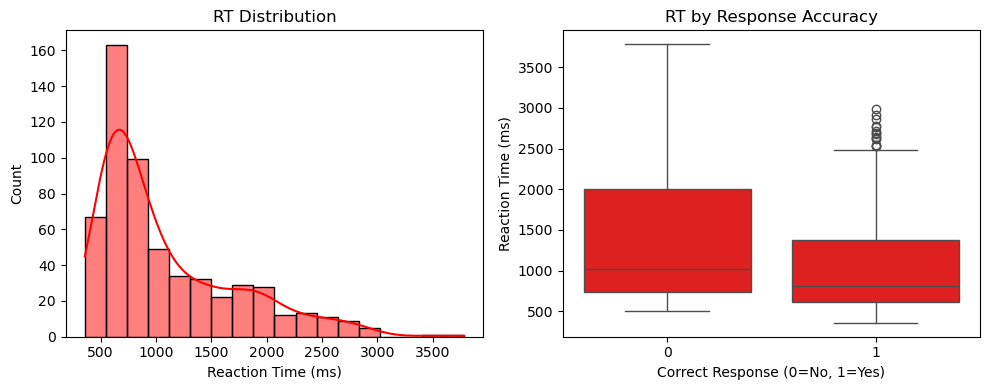

In [7]:
# 20 degrees
print("20 degrees:")
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(df_20['rt'], kde=True, color='blue')
plt.title('RT Distribution')
plt.xlabel('Reaction Time (ms)')

plt.subplot(1, 2, 2)
sns.boxplot(x='correct', y='rt', data=df_20, color='blue')
plt.title('RT by Response Accuracy')
plt.xlabel('Correct Response (0=No, 1=Yes)')
plt.ylabel('Reaction Time (ms)')

plt.tight_layout()
plt.show()

# 45 degrees
print("45 degrees:")
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(df_45['rt'], kde=True, color='red')
plt.title('RT Distribution')
plt.xlabel('Reaction Time (ms)')

plt.subplot(1, 2, 2)
sns.boxplot(x='correct', y='rt', data=df_45, color='red')
plt.title('RT by Response Accuracy')
plt.xlabel('Correct Response (0=No, 1=Yes)')
plt.ylabel('Reaction Time (ms)')

plt.tight_layout()
plt.show()

## Running the Model

In [8]:
stan_code = """
data {
    int<lower=1> N;
    vector[N] c;
    vector[N] y;
}

parameters {
    real<lower=0> v;
    real<lower=0> a;
    real<lower=0> tau;
    real<lower=0, upper=1> beta;
}

model {
    // Priors
    v ~ gamma(3, 1);
    a ~ gamma(3, 1);
    beta ~ beta(2, 2);
    tau ~ gamma(2, 1);

    // Likelihood (Wiener Model)
    for (n in 1:N) {
        if (c[n] == 1) {
            y[n] ~ wiener(a, tau, beta, v);
        }
        else {
            y[n] ~ wiener(a, tau, 1-beta, -v);
        }
    }
}
"""

In [9]:

model = stan.build(stan_code, data={
    'N': len(df_20),
    'c': df_20['correct'].to_numpy(),
    'y': df_20['rt'].to_numpy() / 1000
})

fit_20 = model.sample(num_chains=4, num_samples=2000, num_warmup=1000)

summary_20 = az.summary(fit_20)
summary_20

Building...



Building: found in cache, done.

Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (301/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2200/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2600/12000)
Sampling:  22% (2700/12000)
Sampling:  23% (2800/12000)
Sampling:  24% (2900/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/12000)
Sampling:  27% (3200/12000

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.713,0.060,0.605,0.828,0.001,0.001,5320.0,4880.0,1.0
a,1.951,0.043,1.870,2.030,0.001,0.000,6362.0,4947.0,1.0
tau,0.497,0.007,0.483,0.510,0.000,0.000,5379.0,4475.0,1.0
beta,0.556,0.016,0.524,0.584,0.000,0.000,4836.0,5087.0,1.0


In [10]:
model = stan.build(stan_code, data={
    'N': len(df_45),
    'c': df_45['correct'].to_numpy(),
    'y': df_45['rt'].to_numpy() / 1000
})

fit_45 = model.sample(num_chains=4, num_samples=2000, num_warmup=1000)

summary_45 = az.summary(fit_45)
summary_45

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (301/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2200/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2600/12000)
Sampling:  22% (2700/12000)
Sampling:  23% (2800/12000)
Sampling:  24% (2900/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/1

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.868,0.061,0.759,0.988,0.001,0.001,4735.0,5167.0,1.0
a,2.054,0.047,1.963,2.140,0.001,0.001,5714.0,5501.0,1.0
tau,0.318,0.009,0.302,0.334,0.000,0.000,4928.0,4642.0,1.0
beta,0.564,0.017,0.532,0.593,0.000,0.000,4625.0,4983.0,1.0


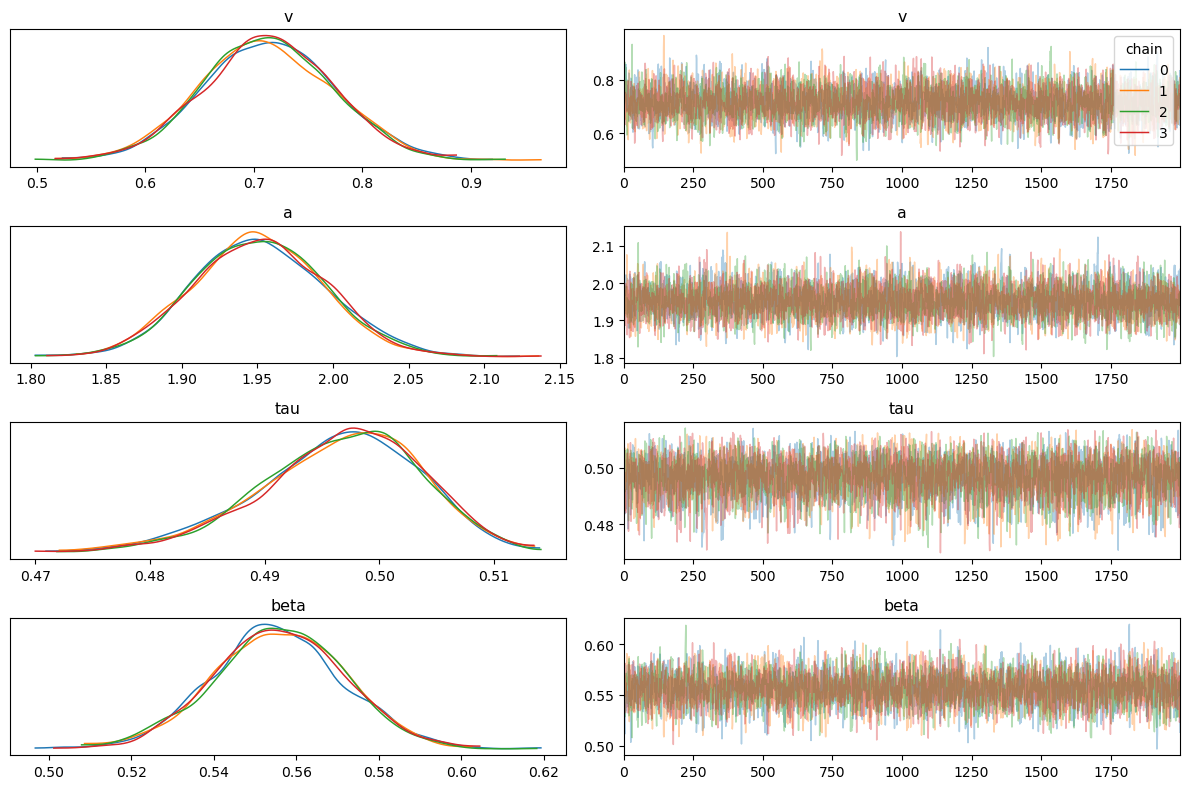

In [11]:
# Traceplots 20 degrees
f = az.plot_trace(fit_20, compact=False, legend=True)
plt.tight_layout()

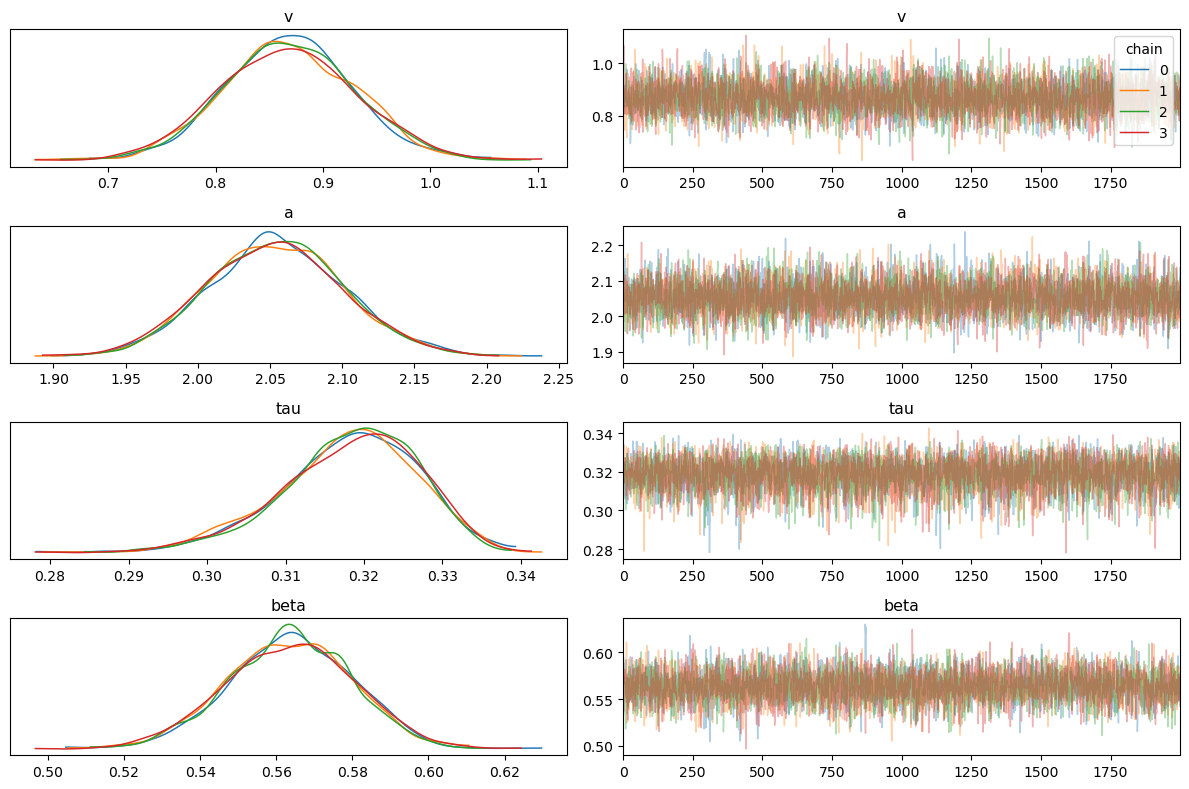

In [12]:
# Traceplots 45 degrees
f = az.plot_trace(fit_45, compact=False, legend=True)
plt.tight_layout()

## Create & Compare Simulated Data from Parameter Estimates

In [13]:
data_20 = np.zeros((df_20.shape[0], 2))

# Create data set
for n in range(df_20.shape[0]):
    data_20[n, :] = simulate_diffusion(
        fit_20["v"].mean(),
        fit_20["a"].mean(),
        fit_20["beta"].mean(),
        fit_20["tau"].mean(),
    )

data_20

array([[1.0605, 1.    ],
       [1.4305, 1.    ],
       [1.1215, 1.    ],
       ...,
       [0.6565, 1.    ],
       [0.6395, 1.    ],
       [0.7155, 1.    ]])

In [14]:
data_45 = np.zeros((df_45.shape[0], 2))

# Create data set
for n in range(df_45.shape[0]):
    data_45[n, :] = simulate_diffusion(
        fit_45["v"].mean(),
        fit_45["a"].mean(),
        fit_45["beta"].mean(),
        fit_45["tau"].mean(),
    )

data_45

array([[0.4502, 1.    ],
       [0.5252, 0.    ],
       [0.5902, 1.    ],
       ...,
       [1.9242, 1.    ],
       [0.9582, 1.    ],
       [0.9622, 1.    ]])

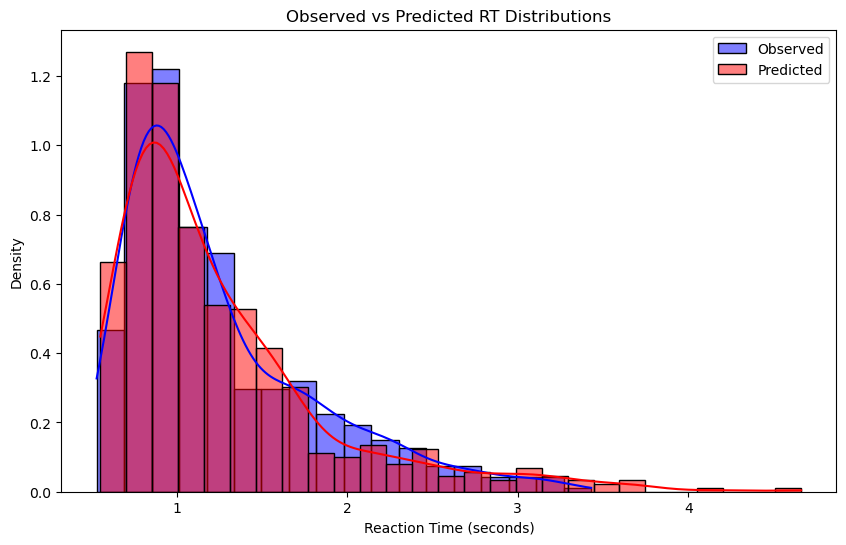

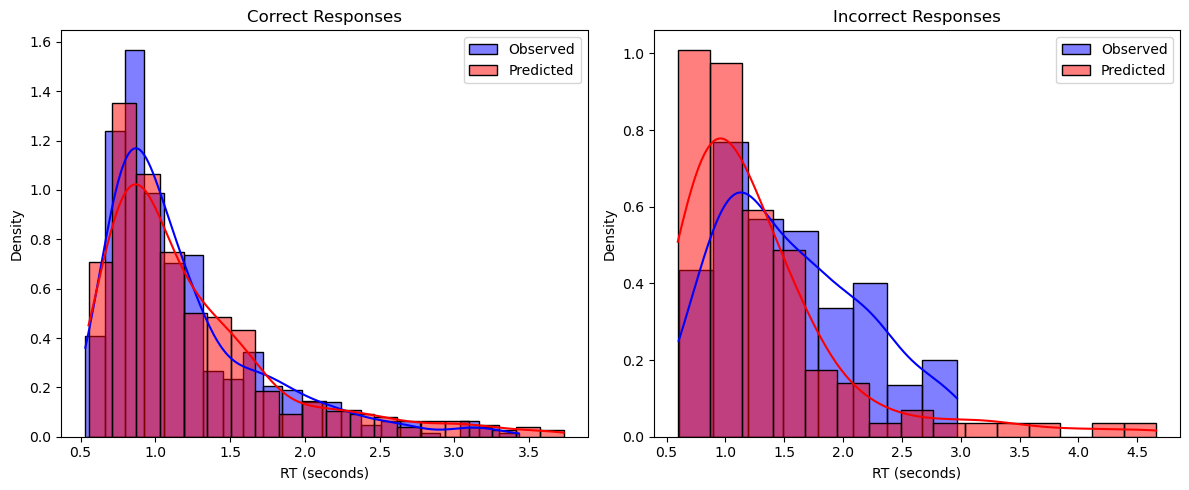

In [15]:
rt_pred = data_20[:, 0]

plt.figure(figsize=(10, 6))
sns.histplot(
    df_20["rt"] / 1000,
    kde=True,
    stat="density",
    label="Observed",
    color="blue",
    alpha=0.5,
)
sns.histplot(
    rt_pred.flatten(),
    kde=True,
    stat="density",
    label="Predicted",
    color="red",
    alpha=0.5,
)
plt.xlabel("Reaction Time (seconds)")
plt.title("Observed vs Predicted RT Distributions")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
obs_correct = df_20.loc[df_20["correct"] == 1, "rt"] / 1000
pred_correct_idx = np.where(data_20[:, 1] == 1)[0]
pred_correct = rt_pred.flatten()[pred_correct_idx]
sns.histplot(
    obs_correct, kde=True, stat="density", label="Observed", color="blue", alpha=0.5
)
sns.histplot(
    pred_correct, kde=True, stat="density", label="Predicted", color="red", alpha=0.5
)
plt.title("Correct Responses")
plt.xlabel("RT (seconds)")
plt.legend()

plt.subplot(1, 2, 2)
obs_incorrect = df_20.loc[df_20["correct"] == 0, "rt"] / 1000
pred_incorrect_idx = np.where(np.array(data_20[:, 1]) == 0)[0]
pred_incorrect = rt_pred.flatten()[pred_incorrect_idx]
sns.histplot(
    obs_incorrect, kde=True, stat="density", label="Observed", color="blue", alpha=0.5
)
sns.histplot(
    pred_incorrect, kde=True, stat="density", label="Predicted", color="red", alpha=0.5
)
plt.title("Incorrect Responses")
plt.xlabel("RT (seconds)")
plt.legend()

plt.tight_layout()
plt.show()

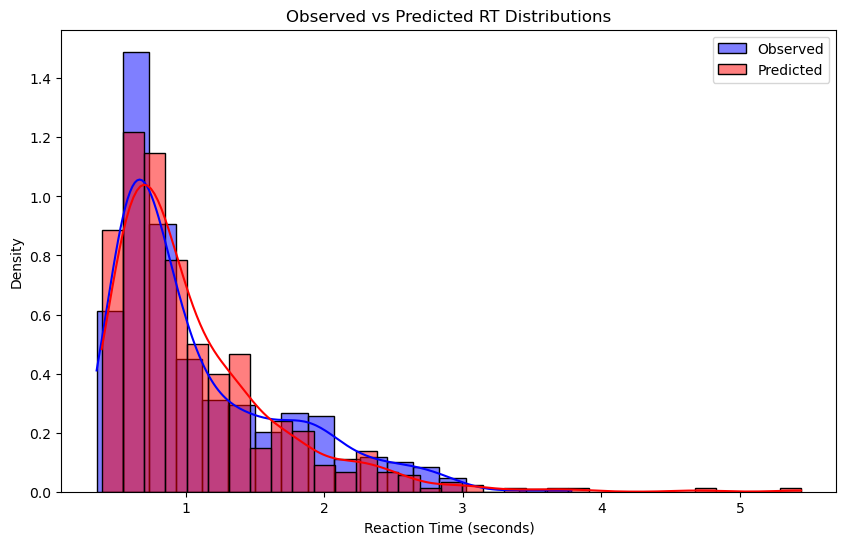

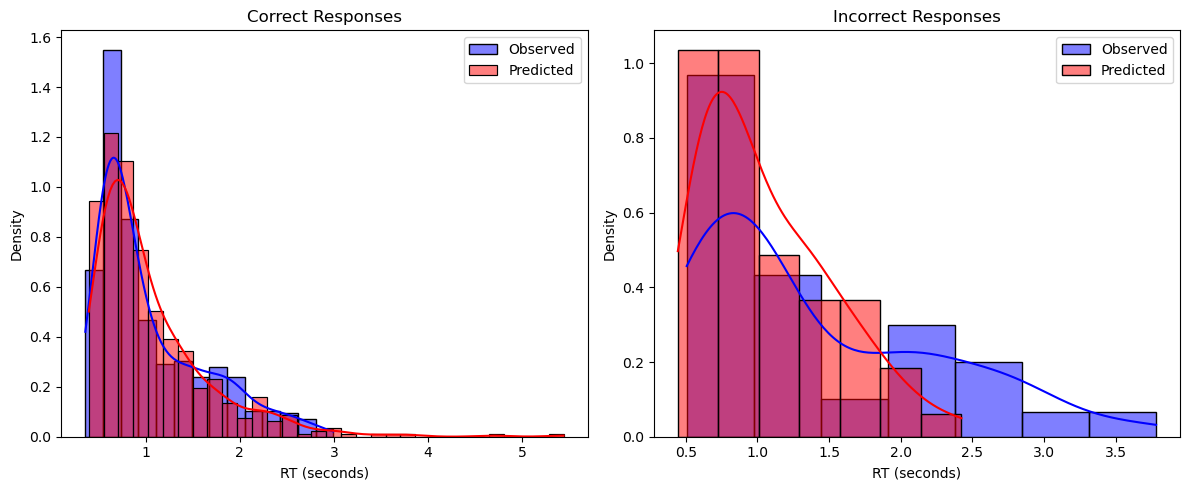

In [16]:
rt_pred = data_45[:, 0]

plt.figure(figsize=(10, 6))
sns.histplot(
    df_45["rt"] / 1000,
    kde=True,
    stat="density",
    label="Observed",
    color="blue",
    alpha=0.5,
)
sns.histplot(
    rt_pred.flatten(),
    kde=True,
    stat="density",
    label="Predicted",
    color="red",
    alpha=0.5,
)
plt.xlabel("Reaction Time (seconds)")
plt.title("Observed vs Predicted RT Distributions")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
obs_correct = df_45.loc[df_45["correct"] == 1, "rt"] / 1000
pred_correct_idx = np.where(data_45[:, 1] == 1)[0]
pred_correct = rt_pred.flatten()[pred_correct_idx]
sns.histplot(
    obs_correct, kde=True, stat="density", label="Observed", color="blue", alpha=0.5
)
sns.histplot(
    pred_correct, kde=True, stat="density", label="Predicted", color="red", alpha=0.5
)
plt.title("Correct Responses")
plt.xlabel("RT (seconds)")
plt.legend()

plt.subplot(1, 2, 2)
obs_incorrect = df_45.loc[df_45["correct"] == 0, "rt"] / 1000
pred_incorrect_idx = np.where(np.array(data_45[:, 1]) == 0)[0]
pred_incorrect = rt_pred.flatten()[pred_incorrect_idx]
sns.histplot(
    obs_incorrect, kde=True, stat="density", label="Observed", color="blue", alpha=0.5
)
sns.histplot(
    pred_incorrect, kde=True, stat="density", label="Predicted", color="red", alpha=0.5
)
plt.title("Incorrect Responses")
plt.xlabel("RT (seconds)")
plt.legend()

plt.tight_layout()
plt.show()

## Compare Parameters Between 20 Degree and 45 Degree Trials

In [17]:
print("Parameter Interpretations:")
print(
    f"- Boundary Separation (a), higher value indicates more cautious decision-making:\n\t- 20 degree: {fit_20['a'].mean():.4f}\n\t- 45 degree: {fit_45['a'].mean():.4f}"
)
print(
    f"- Starting Point (beta), values close to 0.5 indicate no bias\n\t- 20 degree: {fit_20['beta'].mean():.4f}\n\t- 45 degree: {fit_45['beta'].mean():.4f}"
)
print(
    f"- Non-decision Time (tau), time spent on processes outside of evidence accumulation:\n\t- 20 degree: {fit_20['tau'].mean():.4f}\n\t- 45 degree: {fit_45['tau'].mean():.4f}"
)
print(
    f"- Drift Rate (v), higher absolute values indicate faster evidence accumulation:\n\t- 20 degree: {fit_20['v'].mean():.4f}\n\t- 45 degree: {fit_45['v'].mean():.4f}"
)

Parameter Interpretations:
- Boundary Separation (a), higher value indicates more cautious decision-making:
	- 20 degree: 1.9514
	- 45 degree: 2.0540
- Starting Point (beta), values close to 0.5 indicate no bias
	- 20 degree: 0.5557
	- 45 degree: 0.5636
- Non-decision Time (tau), time spent on processes outside of evidence accumulation:
	- 20 degree: 0.4965
	- 45 degree: 0.3182
- Drift Rate (v), higher absolute values indicate faster evidence accumulation:
	- 20 degree: 0.7129
	- 45 degree: 0.8685
